In [1]:
import tensorflow as tf
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
import Utils
%matplotlib inline

In [2]:
vgg16 = tf.keras.applications.VGG16(include_top=False,weights='imagenet')
vgg16_graph = tf.keras.backend.get_session().graph

In [3]:
w_1_1 = vgg16_graph.get_tensor_by_name('block1_conv1/kernel:0')
b_1_1 = vgg16_graph.get_tensor_by_name('block1_conv1/bias:0')
w_1_2 = vgg16_graph.get_tensor_by_name('block1_conv2/kernel:0')
b_1_2 = vgg16_graph.get_tensor_by_name('block1_conv2/bias:0')

w_2_1 = vgg16_graph.get_tensor_by_name('block2_conv1/kernel:0')
b_2_1 = vgg16_graph.get_tensor_by_name('block2_conv1/bias:0')
w_2_2 = vgg16_graph.get_tensor_by_name('block2_conv2/kernel:0')
b_2_2 = vgg16_graph.get_tensor_by_name('block2_conv2/bias:0')

w_3_1 = vgg16_graph.get_tensor_by_name('block3_conv1/kernel:0')
b_3_1 = vgg16_graph.get_tensor_by_name('block3_conv1/bias:0')
w_3_2 = vgg16_graph.get_tensor_by_name('block3_conv2/kernel:0')
b_3_2 = vgg16_graph.get_tensor_by_name('block3_conv2/bias:0')
w_3_3 = vgg16_graph.get_tensor_by_name('block3_conv3/kernel:0')
b_3_3 = vgg16_graph.get_tensor_by_name('block3_conv3/bias:0')

w_4_1 = vgg16_graph.get_tensor_by_name('block4_conv1/kernel:0')
b_4_1 = vgg16_graph.get_tensor_by_name('block4_conv1/bias:0')
w_4_2 = vgg16_graph.get_tensor_by_name('block4_conv2/kernel:0')
b_4_2 = vgg16_graph.get_tensor_by_name('block4_conv2/bias:0')
w_4_3 = vgg16_graph.get_tensor_by_name('block4_conv3/kernel:0')
b_4_3 = vgg16_graph.get_tensor_by_name('block4_conv3/bias:0')

w_5_1 = vgg16_graph.get_tensor_by_name('block5_conv1/kernel:0')
b_5_1 = vgg16_graph.get_tensor_by_name('block5_conv1/bias:0')
w_5_2 = vgg16_graph.get_tensor_by_name('block5_conv2/kernel:0')
b_5_2 = vgg16_graph.get_tensor_by_name('block5_conv2/bias:0')
w_5_3 = vgg16_graph.get_tensor_by_name('block5_conv3/kernel:0')
b_5_3 = vgg16_graph.get_tensor_by_name('block5_conv3/bias:0')

In [4]:
w_4_1

<tf.Tensor 'block4_conv1/kernel:0' shape=(3, 3, 256, 512) dtype=float32_ref>

In [5]:
def unpool_with_argmax(pool, ind, name = None, ksize=[1, 2, 2, 1]):

    """
       Unpooling layer after max_pool_with_argmax.
       Args:
           pool:   max pooled output tensor
           ind:      argmax indices
           ksize:     ksize is the same as for the pool
       Return:
           unpool:    unpooling tensor
    """
    with tf.variable_scope(name):
        input_shape = pool.get_shape().as_list()
        print("input_shape: {0}, ind: {1}".format(pool.shape, ind.shape))
        output_shape = (input_shape[0], input_shape[1] * ksize[1], input_shape[2] * ksize[2], input_shape[3])

        flat_input_size = tf.reduce_prod(input_shape)
        flat_output_shape = [output_shape[0], output_shape[1] * output_shape[2] * output_shape[3]]

        pool_ = tf.reshape(pool, [flat_input_size])
        batch_range = tf.reshape(tf.range(output_shape[0], dtype=ind.dtype), shape=[input_shape[0], 1, 1, 1])
        b = tf.ones_like(ind) * batch_range
        b = tf.reshape(b, [flat_input_size, 1])
        ind_ = tf.reshape(ind, [flat_input_size, 1])
        ind_ = tf.concat([b, ind_], 1)

        ret = tf.scatter_nd(ind_, pool_, shape=flat_output_shape)
        ret = tf.reshape(ret, output_shape)
        return ret

In [6]:
number_of_classes = 12

images=tf.placeholder(dtype=tf.float32,shape=(1, 192, 256, 3))
labels_im=tf.placeholder(dtype=tf.float32,shape=(1, 192, 256, number_of_classes))

#images=tf.placeholder(dtype=tf.float32,shape=(1, 720, 960, 3))
strides = (1,1,1,1)
padding = 'SAME'
max_pooling_ksize = (1,2,2,1)
learning_rate = 0.0001

In [7]:
conv_1_1 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(input = images,filter=w_1_1, strides=strides, padding=padding), b_1_1))
conv_1_2 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(input = conv_1_1,filter=w_1_2, strides=strides, padding=padding), b_1_2))
max_pooling_1, indicies_1 = tf.nn.max_pool_with_argmax(conv_1_2, ksize=max_pooling_ksize,strides=(1,2,2,1), padding='VALID')

conv_2_1 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(input = max_pooling_1,filter=w_2_1, strides=strides, padding=padding), b_2_1))
conv_2_2 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(input = conv_2_1,filter=w_2_2, strides=strides, padding=padding), b_2_2))
max_pooling_2, indicies_2 = tf.nn.max_pool_with_argmax(conv_2_2, ksize=max_pooling_ksize,strides=(1,2,2,1), padding='VALID')

conv_3_1 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(input = max_pooling_2,filter=w_3_1, strides=strides, padding=padding), b_3_1))
conv_3_2 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(input = conv_3_1,filter=w_3_2, strides=strides, padding=padding), b_3_2))
conv_3_3 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(input = conv_3_2,filter=w_3_3, strides=strides, padding=padding), b_3_3))
max_pooling_3, indicies_3 = tf.nn.max_pool_with_argmax(conv_3_3, ksize=max_pooling_ksize,strides=(1,2,2,1), padding='VALID')

conv_4_1 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(input = max_pooling_3,filter=w_4_1, strides=strides, padding=padding), b_4_1))
conv_4_2 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(input = conv_4_1,filter=w_4_2, strides=strides, padding=padding), b_4_2))
conv_4_3 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(input = conv_4_2,filter=w_4_3, strides=strides, padding=padding), b_4_3))
max_pooling_4, indicies_4 = tf.nn.max_pool_with_argmax(conv_4_3, ksize=max_pooling_ksize,strides=(1,2,2,1), padding='VALID')

conv_5_1 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(input = max_pooling_4,filter=w_5_1, strides=strides, padding=padding), b_5_1))
conv_5_2 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(input = conv_5_1,filter=w_5_2, strides=strides, padding=padding), b_5_2))
conv_5_3 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(input = conv_5_2,filter=w_5_3, strides=strides, padding=padding), b_5_3))
#max_pooling_5, indicies_5 = tf.nn.max_pool_with_argmax(conv_5_3, ksize=max_pooling_ksize,strides=(1,2,2,1), padding='VALID', Targmax=tf.int32)
max_pooling_5, indicies_5 = tf.nn.max_pool_with_argmax(conv_5_3, ksize=max_pooling_ksize,strides=(1,2,2,1), padding='VALID')

print("max_pooling_5: {0}".format(max_pooling_5.shape))
upsample_1 = unpool_with_argmax(max_pooling_5, indicies_5, name='upsample_1')
print("upsample_1: {0}".format(upsample_1.shape))
deconv_1_1 = tf.layers.conv2d(inputs=upsample_1, filters=w_5_3.shape[2].value,kernel_size=(3,3),activation=tf.nn.relu, name='deconv_1_1',padding='same')
print("deconv_1_1: {0}".format(deconv_1_1.shape))
deconv_1_2 = tf.layers.conv2d(deconv_1_1, w_5_2.shape[2].value,(3,3),activation=tf.nn.relu, name='deconv_1_2',padding='same')
print("deconv_1_2: {0}".format(deconv_1_2.shape))
deconv_1_3 = tf.layers.conv2d(deconv_1_2, w_5_1.shape[2].value,(3,3),activation=tf.nn.relu, name='deconv_1_3',padding='same')
print("deconv_1_3: {0}".format(deconv_1_3.shape))

upsample_2 = unpool_with_argmax(deconv_1_3, indicies_4, name='upsample_2')
deconv_2_1 = tf.layers.conv2d(upsample_2, w_4_3.shape[2].value,(3,3),activation=tf.nn.relu, name='deconv_2_1',padding='same')
deconv_2_2 = tf.layers.conv2d(deconv_2_1, w_4_2.shape[2].value,(3,3),activation=tf.nn.relu, name='deconv_2_2',padding='same')
deconv_2_3 = tf.layers.conv2d(deconv_2_2, w_4_1.shape[2].value,(3,3),activation=tf.nn.relu, name='deconv_2_3',padding='same')

upsample_3 = unpool_with_argmax(deconv_2_3, indicies_3, name='upsample_3')
deconv_3_1 = tf.layers.conv2d(upsample_3, w_3_3.shape[2].value,(3,3),activation=tf.nn.relu, name='deconv_3_1',padding='same')
deconv_3_2 = tf.layers.conv2d(deconv_3_1, w_3_2.shape[2].value,(3,3),activation=tf.nn.relu, name='deconv_3_2',padding='same')
deconv_3_3 = tf.layers.conv2d(deconv_3_2, w_3_1.shape[2].value,(3,3),activation=tf.nn.relu, name='deconv_3_3',padding='same')

upsample_4 = unpool_with_argmax(deconv_3_3, indicies_2, name='upsample_4')
deconv_4_1 = tf.layers.conv2d(upsample_4, w_2_2.shape[2].value,(3,3),activation=tf.nn.relu, name='deconv_4_1',padding='same')
deconv_4_2 = tf.layers.conv2d(deconv_4_1, w_2_1.shape[2].value,(3,3),activation=tf.nn.relu, name='deconv_4_2',padding='same')

upsample_5 = unpool_with_argmax(deconv_4_2, indicies_1, name='upsample_5')
deconv_5_1 = tf.layers.conv2d(upsample_5, w_1_2.shape[2].value,(3,3),activation=tf.nn.relu, name='deconv_5_1',padding='same')
#deconv_5_2 = tf.layers.conv2d(deconv_5_1, w_1_1.shape[2].value,(3,3),activation=tf.nn.relu, name='deconv_5_2',padding='same')
deconv_5_2 = tf.layers.conv2d(deconv_5_1,number_of_classes,(3,3),activation=tf.nn.relu, name='deconv_5_2',padding='same')
print("deconv_5_2: {0}".format(deconv_5_2.shape))
out = tf.nn.softmax(deconv_5_2)
print("out: {0}".format(out.shape))
print("out: {0}".format(labels_im))
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=out, labels=labels_im))
train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

correctPred = tf.equal(tf.argmax(out,-1), tf.argmax(labels_im,-1))
print("correctPred: {0}".format(correctPred.shape))
accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))
print("acurracy: {0}".format(accuracy.shape))

reverseOneHot = tf.argmax(out,-1)
reverseOneHot = tf.reshape(reverseOneHot,(reverseOneHot.shape[1].value,reverseOneHot.shape[2].value))
print("reverseOneHot: {0}".format(reverseOneHot.shape))


max_pooling_5: (1, 6, 8, 512)
input_shape: (1, 6, 8, 512), ind: (1, 6, 8, 512)
upsample_1: (1, 12, 16, 512)
deconv_1_1: (1, 12, 16, 512)
deconv_1_2: (1, 12, 16, 512)
deconv_1_3: (1, 12, 16, 512)
input_shape: (1, 12, 16, 512), ind: (1, 12, 16, 512)
input_shape: (1, 24, 32, 256), ind: (1, 24, 32, 256)
input_shape: (1, 48, 64, 128), ind: (1, 48, 64, 128)
input_shape: (1, 96, 128, 64), ind: (1, 96, 128, 64)
deconv_5_2: (1, 192, 256, 12)
out: (1, 192, 256, 12)
out: Tensor("Placeholder_27:0", shape=(1, 192, 256, 12), dtype=float32)
correctPred: (1, 192, 256)
acurracy: ()
reverseOneHot: (192, 256)


In [8]:
print(conv_3_3.shape)
print(conv_4_1.shape)

(1, 48, 64, 256)
(1, 24, 32, 512)


In [9]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [10]:
image = imread('../Data/CamVid/train/0001TP_006690.png')
#image = image#[0:360,0:480]
image = image[0:192,0:256] 
image = np.reshape(image,(1,np.shape(image)[0],np.shape(image)[1],3))
type(image)

label_image = imread('../Data/CamVid/trainannot/0001TP_006690.png')
label_image = label_image[0:192,0:256] 
label_image = Utils.convert_label_to_one_hot(label_image)
#image = image#[0:360,0:480]

label_image = np.reshape(label_image,(1,np.shape(label_image)[0],np.shape(label_image)[1],number_of_classes))


In [11]:
#import glob
#image_paths = glob.glob("../Data/Raw_images/*.png")
#image_list = []
#for i in range(0,16):
#    image_list.append(imread(image_paths[i])[0:256,0:512])

#images_arr = np.asarray(image_list)
#print(images_arr.shape)

--- 0.934922456741333 seconds ---
without training:
Loss: 2.4849
Accuracy: 0.132914
Loss: 2.48487
Accuracy: 0.619385
Loss: 2.1943
Accuracy: 0.44401
Loss: 1.99782
Accuracy: 0.620911
Loss: 1.99243
Accuracy: 0.626302
Loss: 1.99178
Accuracy: 0.626953
Loss: 1.99176
Accuracy: 0.626973
Loss: 1.99147
Accuracy: 0.627258
Loss: 1.99139
Accuracy: 0.62734
Loss: 1.99143
Accuracy: 0.627299
Loss: 1.99139
Accuracy: 0.62734
--- 78.71663188934326 seconds ---


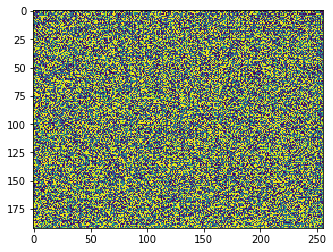

In [12]:
import time

start_time = time.time()

sess.run(max_pooling_5,feed_dict={images: image})

print("--- %s seconds ---" % (time.time() - start_time))

loss_sum,acc_sum = sess.run([loss,accuracy],feed_dict={images: image,labels_im: label_image})
print("without training:")
print("Loss:",loss_sum)
print("Accuracy:",acc_sum)


start_time = time.time()
for i in range(0,100):
    sess.run(train_step,feed_dict={images: image,labels_im: label_image})
    loss_sum,acc_sum = sess.run([loss,accuracy],feed_dict={images: image,labels_im: label_image})
    if i % 10 == 0:
        print("Loss:",loss_sum)
        print("Accuracy:",acc_sum)
        pass

print("--- %s seconds ---" % (time.time() - start_time))

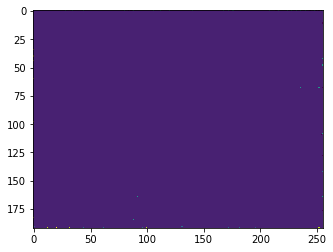

In [13]:
roh = sess.run(reverseOneHot,feed_dict={images: image,labels_im: label_image})

plt.imshow(roh)


In [14]:
roh

array([[1, 1, 1, ..., 1, 0, 5],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ..., 
       [1, 1, 1, ..., 1, 1, 1],
       [1, 3, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int64)

array([[[[ 0.,  1.,  0., ...,  0.,  0.,  0.],
         [ 0.,  1.,  0., ...,  0.,  0.,  0.],
         [ 0.,  1.,  0., ...,  0.,  0.,  0.],
         ..., 
         [ 1.,  0.,  0., ...,  0.,  0.,  0.],
         [ 1.,  0.,  0., ...,  0.,  0.,  0.],
         [ 1.,  0.,  0., ...,  0.,  0.,  0.]],

        [[ 0.,  1.,  0., ...,  0.,  0.,  0.],
         [ 0.,  1.,  0., ...,  0.,  0.,  0.],
         [ 0.,  1.,  0., ...,  0.,  0.,  0.],
         ..., 
         [ 1.,  0.,  0., ...,  0.,  0.,  0.],
         [ 1.,  0.,  0., ...,  0.,  0.,  0.],
         [ 1.,  0.,  0., ...,  0.,  0.,  0.]],

        [[ 0.,  1.,  0., ...,  0.,  0.,  0.],
         [ 0.,  1.,  0., ...,  0.,  0.,  0.],
         [ 0.,  1.,  0., ...,  0.,  0.,  0.],
         ..., 
         [ 1.,  0.,  0., ...,  0.,  0.,  0.],
         [ 1.,  0.,  0., ...,  0.,  0.,  0.],
         [ 1.,  0.,  0., ...,  0.,  0.,  0.]],

        ..., 
        [[ 0.,  1.,  0., ...,  0.,  0.,  0.],
         [ 0.,  1.,  0., ...,  0.,  0.,  0.],
         [ 0., 

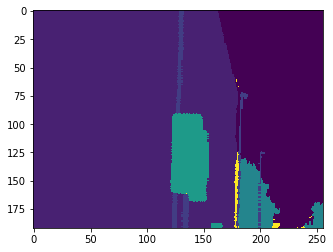

In [18]:
im = imread('../Data/CamVid/trainannot/0001TP_006690.png')
im = im[0:192, 0:256]
plt.imshow(im)